In [2]:
import torch

## Notebook objectives
1. Leverage PyTorch primitives for almost all aspects of our training loop

# Define the neural net model

In [3]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

    def backward(self, loss):
        loss.backward()

The `forward` method in the above class looks clunky because I'm passing the inputs through each layer. For larger models, this gets difficult to write and that's where PyTorch's `nn.Sequential` class comes to help.

In [11]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

    def backward(self, loss):
        loss.backward()

In [12]:
input_dim = 10
output_dim = 1
n_samples = 25

# Creating a sample train, val and test dataset

In [25]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

# torch.random.manual_seed(42)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


# Run the forward pass

In [14]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred - train_y)).sum()

    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  382.122925 | val_loss:  388.373779
 epoch:   1 | train_loss:  372.611084 | val_loss:  372.471161
 epoch:   2 | train_loss:  354.606659 | val_loss:  350.499939
 epoch:   3 | train_loss:  330.164307 | val_loss:  324.307068
 epoch:   4 | train_loss:  301.663452 | val_loss:  296.076324
 epoch:   5 | train_loss:  271.829865 | val_loss:  268.049194
 epoch:   6 | train_loss:  243.390366 | val_loss:  242.294800
 epoch:   7 | train_loss:  218.721970 | val_loss:  220.620636
 epoch:   8 | train_loss:  199.857727 | val_loss:  204.301926
 epoch:   9 | train_loss:  187.693588 | val_loss:  194.162384
 epoch:  10 | train_loss:  182.647736 | val_loss:  190.127975
 epoch:  11 | train_loss:  184.576035 | val_loss:  191.809235
 epoch:  12 | train_loss:  192.827316 | val_loss:  198.289032
 epoch:  13 | train_loss:  205.979248 | val_loss:  208.285400
 epoch:  14 | train_loss:  222.494324 | val_loss:  220.295792
 epoch:  15 | train_loss:  240.676544 | val_loss:  232.722260
 epoch: 

There are PyTorch primitives to help simplify this code.
1. Weight updates do not have to be manually done. PyTorch's `optim.SGD` optimizer helps us do it in a simpler way.
2. Loss calculation can be simplified to using PyTorch's `nn.MSE` loss.
3. In the backward pass, instead of doing `clf.backward(loss)`, as we are using the PyTorch's built in loss, we can simply do `loss.backward()`.

Let's see how that simplifies our training loop.

In [21]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.00001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred, train_y) #torch.square(torch.abs(y_pred - train_y)).sum()

    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()
    # for param in clf.parameters():
    #     if param.grad is not None:
    #         param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds, val_y)
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

/Users/phani/Work/Adhoc/projects/learning-ai/learn-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([25])) that is different to the input size (torch.Size([25, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: Found dtype Long but expected Float

In [23]:
print(y_pred.dtype, train_y.dtype)
print(y_pred.shape, train_y.shape)

torch.float32 torch.int64
torch.Size([25, 1]) torch.Size([25])


Clearly, the inputs to the loss calculation are of different types and PyTorch doesn't seem to like it. Let's fix it and ensure the tensors are of the same size.

In [26]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.00001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  1.315185 | val_loss:  1.390863
 epoch:   1 | train_loss:  1.315120 | val_loss:  1.390728
 epoch:   2 | train_loss:  1.314991 | val_loss:  1.390526
 epoch:   3 | train_loss:  1.314797 | val_loss:  1.390257
 epoch:   4 | train_loss:  1.314539 | val_loss:  1.389919
 epoch:   5 | train_loss:  1.314216 | val_loss:  1.389515
 epoch:   6 | train_loss:  1.313829 | val_loss:  1.389043
 epoch:   7 | train_loss:  1.313377 | val_loss:  1.388505
 epoch:   8 | train_loss:  1.312861 | val_loss:  1.387899
 epoch:   9 | train_loss:  1.312281 | val_loss:  1.387226
 epoch:  10 | train_loss:  1.311636 | val_loss:  1.386486
 epoch:  11 | train_loss:  1.310928 | val_loss:  1.385679
 epoch:  12 | train_loss:  1.310155 | val_loss:  1.384805
 epoch:  13 | train_loss:  1.309319 | val_loss:  1.383865
 epoch:  14 | train_loss:  1.308418 | val_loss:  1.382858
 epoch:  15 | train_loss:  1.307454 | val_loss:  1.381784
 epoch:  16 | train_loss:  1.306427 | val_loss:  1.380645
 epoch:  17 | 

The loss values seem to be off. I think the gradient is getting accumulated. We need to reset the gradients in each iteration.

In [28]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

# torch.random.manual_seed(42)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


In [29]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.00001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  1.150317 | val_loss:  1.279562
 epoch:   1 | train_loss:  1.150251 | val_loss:  1.279498
 epoch:   2 | train_loss:  1.150185 | val_loss:  1.279434
 epoch:   3 | train_loss:  1.150118 | val_loss:  1.279370
 epoch:   4 | train_loss:  1.150053 | val_loss:  1.279306
 epoch:   5 | train_loss:  1.149987 | val_loss:  1.279243
 epoch:   6 | train_loss:  1.149921 | val_loss:  1.279179
 epoch:   7 | train_loss:  1.149854 | val_loss:  1.279115
 epoch:   8 | train_loss:  1.149789 | val_loss:  1.279051
 epoch:   9 | train_loss:  1.149723 | val_loss:  1.278988
 epoch:  10 | train_loss:  1.149657 | val_loss:  1.278924
 epoch:  11 | train_loss:  1.149591 | val_loss:  1.278860
 epoch:  12 | train_loss:  1.149525 | val_loss:  1.278797
 epoch:  13 | train_loss:  1.149459 | val_loss:  1.278733
 epoch:  14 | train_loss:  1.149393 | val_loss:  1.278669
 epoch:  15 | train_loss:  1.149327 | val_loss:  1.278605
 epoch:  16 | train_loss:  1.149261 | val_loss:  1.278542
 epoch:  17 | 

Although this is the right thing to do, we see a difference between my implementation vs PyTorch's loss implementation. Is it because of the tensor dimension mismatch?

In [32]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred.squeeze() - train_y.float())).sum()

    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds.squeeze() - val_y.float())).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  16.586596 | val_loss:  14.752296
 epoch:   1 | train_loss:  16.569662 | val_loss:  14.729992
 epoch:   2 | train_loss:  16.535877 | val_loss:  14.696644
 epoch:   3 | train_loss:  16.485401 | val_loss:  14.652384
 epoch:   4 | train_loss:  16.418470 | val_loss:  14.597387
 epoch:   5 | train_loss:  16.335407 | val_loss:  14.531866
 epoch:   6 | train_loss:  16.236593 | val_loss:  14.456077
 epoch:   7 | train_loss:  16.122498 | val_loss:  14.370312
 epoch:   8 | train_loss:  15.993653 | val_loss:  14.274902
 epoch:   9 | train_loss:  15.850651 | val_loss:  14.170212
 epoch:  10 | train_loss:  15.694147 | val_loss:  14.056633
 epoch:  11 | train_loss:  15.524858 | val_loss:  13.934597
 epoch:  12 | train_loss:  15.343538 | val_loss:  13.804554
 epoch:  13 | train_loss:  15.151001 | val_loss:  13.666979
 epoch:  14 | train_loss:  14.948164 | val_loss:  13.522488
 epoch:  15 | train_loss:  14.735858 | val_loss:  13.371492
 epoch:  16 | train_loss:  14.514977 | v

Yes, that partly resolved the problem. We still see a difference though. I wonder why.

# Look at model details and data details

In [35]:
clf

NeuralNet(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [37]:
sum([p.numel() for p in clf.parameters()])

61

In [47]:
clf.summary()

AttributeError: 'NeuralNet' object has no attribute 'summary'

To observe a model summary just like the amazing summary by tensorflow, we use `torchinfo` library for simplicity.

In [55]:
from torchinfo import summary

model = NeuralNet(input_dim=10, hidden_dim=5, output_dim=1)
summary(model, input_size=(1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 5]                    55
│    └─ReLU: 2-2                         [1, 5]                    --
│    └─Linear: 2-3                       [1, 1]                    6
Total params: 61
Trainable params: 61
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [39]:
train_X

tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
         -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00],
        [-3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
          7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01],
        [-7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
          1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02],
        [-2.5158e-01,  8.5986e-01, -1.3847e+00, -8.7124e-01, -2.2337e-01,
          1.7174e+00,  3.1888e-01, -4.2452e-01,  3.0572e-01, -7.7459e-01],
        [-1.5576e+00,  9.9564e-01, -8.7979e-01, -6.0114e-01, -1.2742e+00,
          2.1228e+00, -1.2347e+00, -4.8791e-01, -9.1382e-01, -6.5814e-01],
        [ 7.8024e-02,  5.2581e-01, -4.8799e-01,  1.1914e+00, -8.1401e-01,
         -7.3599e-01, -1.4032e+00,  3.6004e-02, -6.3477e-02,  6.7561e-01],
        [-9.7807e-02,  1.8446e+00, -1.1845e+00,  1.3835e+00,  1.4451e+00,
          8.5641e-01,  2.2181e+0

It's very hard to inspect tensors. `lovely_tensors` solves this problem.

In [44]:
import lovely_tensors as lt
lt.monkey_patch()

train_X

tensor[25, 10] n=250 x∈[-2.510, 2.218] μ=0.052 σ=0.987

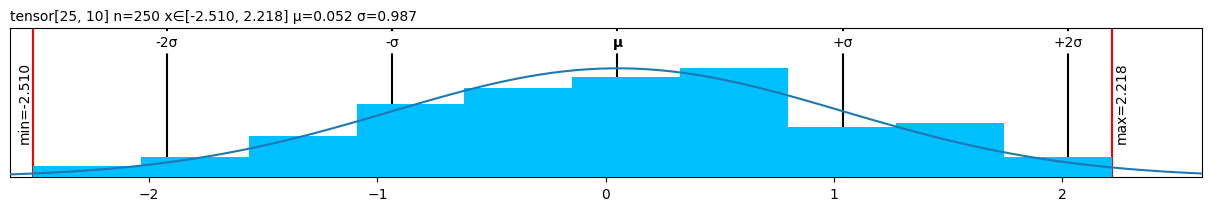

In [45]:
train_X.plt

# Plot the losses and grad norms

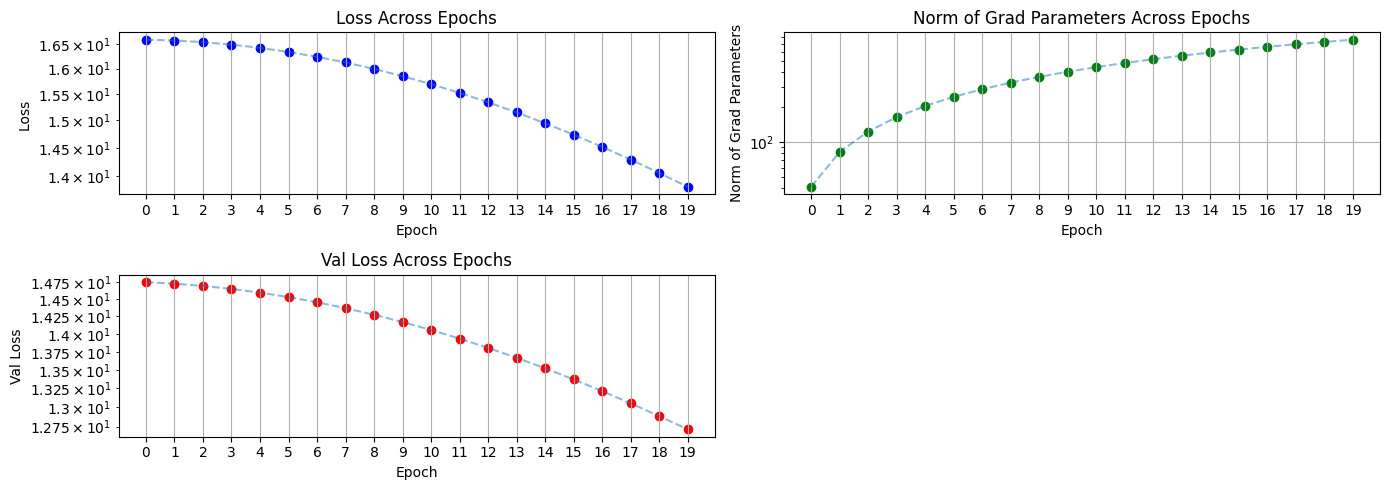

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()